In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy import signal
from misc_tools.print_latex import print_tex

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

***
# Graphs and Graph Neural Networks (GNNs)
Great resource: https://distill.pub/2021/gnn-intro/.

My notes are remarks and thoughts after studying this and other resources.
## What are graphs?
Graphs are useful for representing data where entries (nodes/vertices) are related in specific way (connected via edges).


Good examples of graphs are connections in social networks and molecular structures.

It is common to represent graph $G$ as $\{ G, V, E \}$, where $V$ is a set of nodes/vertices: $V = \{ n_i \}_{i \in \{1,\dots,N\}} $ and edges are in set: $E = \{ (i,j) \}_{i,j \in \{1,\dots,N\}}$

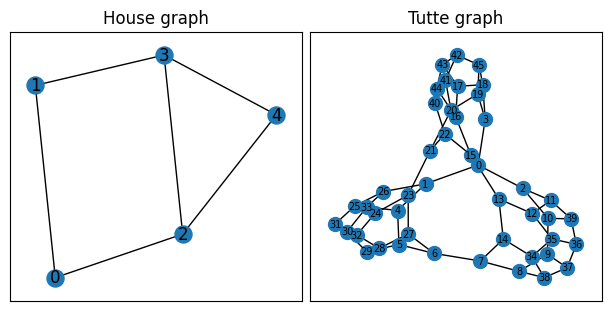

In [2]:
np.random.seed(1337)
G_house = nx.house_graph()
G_tutte = nx.tutte_graph()
fig, ax = plt.subplots(1, 2, figsize = (6,3), layout='constrained')
nx.draw_networkx(G_house, node_size = 150, ax=ax[0])
ax[0].set_title('House graph');
nx.draw_networkx(G_tutte, node_size = 100, ax=ax[1], font_size = 7)
ax[1].set_title('Tutte graph');

### Adjacency matrix
Graph node connectivity can be represented via adjacency matrix $A$ where, in simplest case, entry $A_{i,j} \in \{0,1\}$ shows whether node $n_i$ and node $n_j$ are connected.

`for more info see ../../graphs/graph_stuff.ipynb`

In [3]:
A = nx.adjacency_matrix(G_house).todense()
print_tex('A =', A)

<IPython.core.display.Math object>

### Graph degree
Node degree shows the number of node neighbors. 

Graph-wise statistics on node degree is important to analyze graph complexity.

In [4]:
print_tex(';\ '.join([f'degree(n_{n})={i}' for n,i in G_house.degree()]))
print('Number of nodes', len(G_house.nodes))
print('Number of edges', len(G_house.edges))
print('Average degree', sum(dict(G_house.degree).values()) / len(G_house.nodes))
print_tex('D = ', np.diag([i for n,i in G_house.degree()]))

<IPython.core.display.Math object>

Number of nodes 5
Number of edges 6
Average degree 2.4


<IPython.core.display.Math object>

# Connectivity in image convolution/cross-correlation (CAN SKIP IF FAMILIAR)

Few concepts that will be useful for Graph Neural Networks (GNNs) are shared with process of image convolutions.

In fact, image can be seen as a graph with nodes on a regular grid and connectivity is limited by pixel's surrounding neighbors.

During convolution image data around a pixel is aggregated/reduced from its local neighborhood.

Size of a neighborhood is set by a convolution kernel. For a kernel of radius 1, you get from 3 to 8 neighbors, depending on sampling location.

### An example of measuring number of neighbors using a kernel
Counting neighbors reduces to summation with weights 1. 

In [1]:
def neighbor_count(x): 
    k = np.ones((x,x))
    k[x//2,x//2] = 0    # dont count center pixel
    return k

def rem_ticks(ax, ticks, lw = 1):
    for a in ax:
        a.set_xticks(ticks);a.set_yticks(ticks);a.set_xticklabels([]);a.set_yticklabels([]);a.grid(color='gray', lw = lw)
        a.tick_params(colors=(0,0,0,0));

img = np.ones((4,4))
num_neighbors = signal.convolve2d(img, neighbor_count(3), boundary='fill', mode='same', fillvalue=0)# pad zeros

fig, ax = plt.subplots(1,1, figsize = (6,3), layout='constrained', facecolor = 'k')
ax = [ax]
ax[0].matshow(num_neighbors)
for (i,j), v in np.ndenumerate(num_neighbors):
    ax[0].text(i, j, int(v), va='center', ha='center', color = 'Red', fontsize = 20)
rem_ticks(ax, np.arange(0.5, 4, 1), lw = 3)

NameError: name 'np' is not defined

* While neighbor count is not constant, for images its not less then 3 and more than 8. There are ways to deal with it. For example image padding.

### 'Propagation of information' using convolution
You can think that kernel size shows how 'aware' each pixel becomes of its far neighbors during one convolution pass.

This can be seen as information can propagation distance:

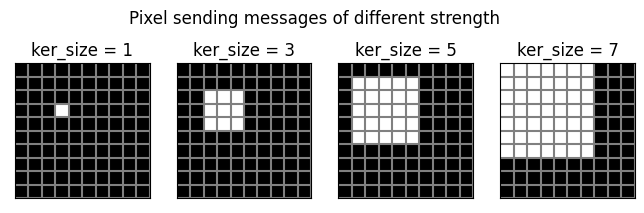

In [6]:
img = np.zeros((10,10))
img[3,3] = 1

ticks = np.arange(0.5, 10, 1)
fig, ax = plt.subplots(1,4, figsize = (8,2.5))

ker = lambda x: np.ones((x,x))/x**2

rem_ticks(ax,ticks, lw = 1.5)
ker_size = 1
for i in range(4):
    img2 = img.copy()
    img2 = signal.convolve2d(img2, ker(ker_size), boundary='symm', mode='same')
    ax[i].imshow(img2, 'gray')
    ax[i].set_title(f'{ker_size = }')
    ker_size += 2
    
fig.suptitle('Pixel sending messages of different strength');

Alternatively, we can apply kernel of a given size repeatedly with a similar (but not the same) result.

Repeated application of a method  reminds of working principle of Recurrent Neural Networks (RNN), where data is cyclically processed in a RNN cell, in a process which is called **'unfolding'**.

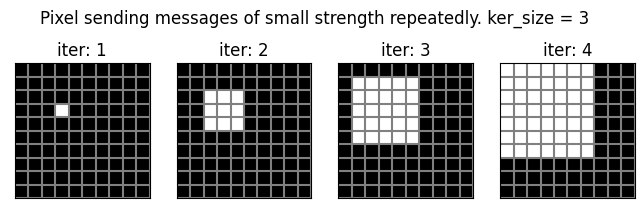

In [7]:
ker_size = 3
fig, ax = plt.subplots(1,4, figsize = (8,2.5))
rem_ticks(ax,ticks, lw = 1.5)
#plt.subplots_adjust(top=1.4)
img2 = img.copy()

for i in range(4):
    ax[i].imshow(img2 > 0, 'gray')
    img2 = signal.convolve2d(img2, ker(ker_size), boundary='symm', mode='same')
    ax[i].set_title(f'iter: {i + 1}')
    
fig.suptitle('Pixel sending messages of small strength repeatedly. ' + f'{ker_size = }');


<b>Observations</b>- information can be propagated via:
1. long connections (here kernel size)
2. 'diffused' via repeated shorter queries

***

## Graph Convolutional Neural Networks (GCNN)


GNNs, like most Deep Learning (DL) NNs, process large matrices, which is accelerated via CPU/GPU parallelization.<br>
Construction of these matrices is not a trivial task, specially since graph data is very different from generic NN tabular input data.

Arbitrary graph will contain $N$ nodes (and $N_e$ edges)
$$V = \{n_1, n_2,\dots , n_N\}$$

Graph data is both unordered and has no defined size, so is impossible to construct a single matrix that describes an arbitrary graph.<br>
This uncertainty is a major downside of using graphs with NNs, since NNs are working by learning and applying to data a weight matrix of a set shape.<br>
In order to make data compatible with NN, we must change how we introduce it into NN and how its processed inside.

### Node features
Graph node represents an object which possesses some form of information.<br>
In order to make this information compatible with NN, it should be encoded into feature vector.

Lets define feature of i-th node $n_i$ as a vectors $\vec{h}_i$ 
$$\vec{h}_i \in \R^F , \ i \in \{ 1,2,\dots, N \}$$ 
To be consistent with original definitions, we will view feature vector as row vector $\vec{h}_i^T$.

Such feature representation can be processed via classical DL.

#### Classical Deep Learning approach and its failure

In spirit of DL we can apply linear map $W_h$
$$W_h \in \R^{F \times F}$$
on each feature $\vec{h}^T$ to transform its contents
$$
\vec{{ h}}_{new}^T = \sigma( \vec{h}^T W_h + \vec{b}_h)
$$
Or do it <i>en masse</i> by packing features into matrix $H$ of shape $(N, F)$
$$ H = 
\begin{bmatrix}
\vec{h}_1 & \vec{h}_2 &  \dots & \vec{h}_N
\end{bmatrix}^T
$$
$$
H_{new} = \sigma( H W_h + \vec{b_h})
$$

`+` This approach is independent on number of nodes on a graph (learned weights matrix $W_h$ is applied to a feature independently).<br>
`-` Mapping only updates feature of a node based on itself and does not leverage `connectivity` of nodes.


### Permutation invariance/aggregation

Out classical DL approach can be made more robust if we learn to represent node's $n_i$ feature, such that it also contains information about its neighbors  $\{ n_j \in \mathcal{N}(n_i) \}$

This process is called `aggregation`, and we can obtain aggregated feature $\vec{h}_{agg, i}$ by applying aggregation function $\mathcal{F}_{agg}$ to all of node's neighbors.

$$\vec{h}_{agg, i} = \mathcal{F}_{agg}({\{ \forall n_j \in \mathcal{N}(n_i)} \}) $$

And process all nodes by 'packing' all $\vec{h}_{agg, i}$ into $H_{aggregated}$
$$
H_{new} = \sigma( H_{aggregated}W_h + \vec{b_h})
$$

Since input data is modified based on neighbor data its more correct to refer to $\vec{h}_{agg, i}$ as an `embedding` of a node.

Again, this procedure should be conducted in a way thats invariant to number of neighbors and order in which neighbor's features are passed into algorithm. Latter is often referred as being `permutation invariant`.


Elementary aggregation functions that are order invariant are:
* $\mathcal{F}_{1} \rightarrow$ sum( $h_1, h_2, h_3$) = sum( $h_3, h_1, h_2$) 
* $\mathcal{F}_{2} \rightarrow$ mean($h_1, h_2, h_3$) = mean($h_3, h_1, h_2$)
* $\mathcal{F}_{3} \rightarrow$ max( $h_1, h_2, h_3$) = max( $h_3, h_1, h_2$)

With mean and max being also count invariant.


### Aggregation via Adjacency matrix
Adjacency matrix contains information on connectivity between nodes and can be used for aggregation.

Limitation of adjacency matrix is that encodes only neighbors one edge away. If we were to use it for aggregation, in order to 'diffuse' information from far away, we would have to conduct aggregation multiple times. This, of course, closely mimics behavior we observed in convolution on images.

Proper term for such information 'diffusion' is <b>Message Passing</b>

Lets consider aggregation function that is based on either $sum$ or/and $mean$ functions:

$$\vec{h}_{agg} = \mathcal{F}_{sum}(\mathcal{N}(n)) = \sum_{h_j \in \mathcal{N}(n)} {\vec{h_j}}$$
$$\mathcal{F}_{mean}(\mathcal{N}(n)) = \frac{1}{||\mathcal{N}(n)||} \mathcal{F}_{sum}(\mathcal{N}(n))$$

How can we turn these expressions into matrix-vector multiplications? 

We know that matrix-vector (/matrix-matrix) multiplication can be viewed as forming a linear combination of rows or columns.<br>

If our graph shows that node $n_2, \ n_3$ are neighbors of nodes $n_1$, we can gather their features via `summation function` via matrix multiplication:

$$
\vec{h}_{agg,1}^T = 
\vec{h}_2^T + \vec{h}_3^T = 
0\cdot \vec{h}_1^T + 1\cdot \vec{h}_2^T + 1\cdot \vec{h}_3^T + 0\cdot \vec{h}_4^T + \dots=
\begin{bmatrix}
0 & 1 &  1 & 0 &\dots 
\end{bmatrix}
\begin{bmatrix}
\vec{h}_1^T \\ \vec{h}_2^T \\  \vdots \\ \vec{h}_N^T
\end{bmatrix}=
\begin{bmatrix}
0 & 1 &  1 & 0 &\dots 
\end{bmatrix}
H
$$

Left matrix is nothing else than row of an `adjacency matrix`!

$$
H_\mathrm{aggregated} = A H
$$


Notice, if graph had only self-connections and $A = I$
$$\vec{h}_{agg,1}^T = \vec{h}_1^T \rightarrow H_\mathrm{aggregated} = H$$
We would return to our naive DL approach
$$
H_{new} = \sigma( H W_h + \vec{b_h})
$$

In fact, its common that graph data usually does not include self loop ($A_{i,i} = 0$), but it is beneficial to include them into GNN for 'robustness'.<br>
Adjacency matrix is modified as
$$\tilde A = A + I \rightarrow
H_\mathrm{aggregated} = \tilde A H
$$
$$H_{new} = \sigma( \tilde A H W_h + \vec{b_h})$$

### Aggregation weights

For aggregation we are using adjacency matrix filled with either 1s or 0s.<br>
<i>Does that mean that nodes with fewer neighbors will tend to accumulate smaller 'values' than nodes with more neighbors?</i><br>
Yes. In fact binary $A$ does not account whether connection between nodes is strong or weak. More appropriate approach would be to use edge weights, but these are not always available.

Fortunately, we have access to number of neighbors of node via `degree matrix` $D = {diagonal}([d_1, \dots, d_N])$.<br> 
We can say that if a node $n_i$ has $d_i$ neighbors, node will message only a fraction $\frac{1}{d_i}\vec{h}_i^T$ of a state to each neighbor.

$$H_{weighted}=
D^{-1} H=
\begin{bmatrix}
\frac{1}{d_1} & &\\
& \frac{1}{d_2} & & \\ 
& & \ddots & \\
& & & \frac{1}{d_N}
\end{bmatrix}
\begin{bmatrix}
\vec{h}_1^T \\ \vec{h}_2^T \\  \vdots \\ \vec{h}_N^T
\end{bmatrix}=
\begin{bmatrix}
\frac{\vec{h}_1^T}{d_1} \\ \frac{\vec{h}_2^T}{d_2} \\  \vdots \\ \frac{\vec{h}_N^T}{d_N}
\end{bmatrix}
$$

So layer expression will be:
$$H_{new} = \sigma( \tilde A D^{-1} H W_h + \vec{b_h})$$
In practice, features in H are scaled by $D^{-\frac{1}{2}} H$ and to 'compensate', rows of $A$ are also rescaled as $D^{-\frac{1}{2}} A$

$$H_{new} = \sigma( D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}} H W_h + \vec{b_h})$$

This approach is used for symmetric normalization, which produces more stable message passing.

### GNN layer unfolding and finalization

Similarly to image convolution, message passing can be repeated multiple times ($K$) to improve information exchange with farthest neighbors. We adopt iteration idex `l` from original paper.
$$H^{l+1} = \sigma( D^{-\frac{1}{2}} \tilde A D^{-\frac{1}{2}} H^l W_h + \vec{b_h})$$

Final embedding $H^{K}$ can be passed though classical dense layer for final result.
$$Y_{out} = \sigma(W_f H_{flatten}^{K} + \vec{b_f})

### Node, Edge, Global task level (predictions)
Once node or edge features are 'distilled' into one agglomerated feature vector, we use it for predicting or modifying other features.

Using DL, model can learn linear maps that modify features of nodes based on edge features, or other way around.

At some instance it may be required to pool (agglomerate) features from all nodes/edges, which is called Global Prediction.

* `see .GNN_layer_pytorch.ipynb for implementation of a forward pass and a solved example`

### (NOT CORRECT, DISREGARD) Representing graph data as a matrix (spoilers: it fails)
But, because graphs are constructed of <b>unordered</b> data, there is no consistent/unique way to represent it as matrices.

i.e for edges of nodes $$E = \{(n_1,n_2),(n_3,n_1)\}$$ and
$$V_1 = \{n_1,n_2,n_3\} \rightarrow 
A_1 = 
\begin{bmatrix}
    & V_1[1]   & V_1[2]   & V_1[3]\\
V_1[1] & 0     & 1     & 0\\
V_1[2] & 0     & 0     & 0\\
V_1[3] & 1     & 0     & 0\\
\end{bmatrix}
$$

and for same nodes presented in different order ($n_1 \circlearrowright n_3$):

$$V_2 = \{n_3,n_2,n_1\} \rightarrow 
A_2 = 
\begin{bmatrix}
    & V_2[1]   & V_2[2]   & V_2[3]\\
V_2[1] & 0     & 0     & 1\\
V_2[2] & 0     & 0     & 0\\
V_2[3] & 0     & 1     & 0\\
\end{bmatrix}
$$

Results in <b>different adjacency matrix. </b>